# 03_baseline_train
- Author: 
- Date: 2025-10-23
- Goal: Baseline CNN 학습 및 로깅
- Input: 
- Output: 
- Metrics: acc@val, loss@train
- Repro: seed=42, device=auto, config=../configs/


In [8]:
# ================================================================
# 03. Error Analysis & Visualization on Colored MNIST
#   - Load preprocessed Colored MNIST (train/val only)
#   - Train a single chosen model per task (digit / fg / bg)
#   - Analyze misclassifications (오분류):
#       * Confusion matrix
#       * Per-class accuracy / error rate
#       * Source-wise error (raw / deskew / font / geom)
#       * Misclassified sample visualization
#   - Save results as CSV + figures
# ================================================================

# ================================
# Cell 1. Imports & global config
# ================================
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost (optional; 사용할 때만 install 필요)
from xgboost import XGBClassifier

# Notebook
# %matplotlib inline   # 주피터 노트북이면 주석 해제해도 됨

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

print("[INFO] Libraries imported.")

[INFO] Libraries imported.


In [9]:
# ===================================
# Cell 2. Paths & load preprocessed npz
# ===================================
BASE_DIR = os.getcwd()

PROC_DIR = os.path.join(BASE_DIR, "data", "processed", "colored_mnist")
NPZ_PATH = os.path.join(PROC_DIR, "colored_mnist_100k_train_val.npz")

RESULTS_ROOT_DIR   = os.path.join(BASE_DIR, "results")
RESULTS_ANALYSIS_DIR = os.path.join(RESULTS_ROOT_DIR, "error_analysis")
FIGURES_DIR        = os.path.join(RESULTS_ANALYSIS_DIR, "figures")
TABLES_DIR         = os.path.join(RESULTS_ANALYSIS_DIR, "tables")

os.makedirs(RESULTS_ANALYSIS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)

IMG_SHAPE = (28, 28, 3)

print("[INFO] BASE_DIR          :", BASE_DIR)
print("[INFO] NPZ_PATH          :", NPZ_PATH)
print("[INFO] ANALYSIS_DIR      :", RESULTS_ANALYSIS_DIR)

if not os.path.exists(NPZ_PATH):
    raise FileNotFoundError(f"[ERROR] Preprocessed npz not found at: {NPZ_PATH}")

data = np.load(NPZ_PATH)

X_train = data["X_train"]  # (N_train, 2352)
X_val   = data["X_val"]    # (N_val, 2352)

y_digit_train = data["y_digit_train"]
y_digit_val   = data["y_digit_val"]

y_fg_train = data["y_fg_train"]
y_fg_val   = data["y_fg_val"]

y_bg_train = data["y_bg_train"]
y_bg_val   = data["y_bg_val"]

source_train = data["source_train"]  # raw / deskew / font / geom
source_val   = data["source_val"]

COLOR_PALETTE = data["color_palette"]

print("[INFO] Dataset loaded.")
print("  X_train :", X_train.shape, X_train.dtype)
print("  X_val   :", X_val.shape)
print("  y_digit :", y_digit_train.shape, y_digit_val.shape)
print("  y_fg    :", y_fg_train.shape, y_fg_val.shape)
print("  y_bg    :", y_bg_train.shape, y_bg_val.shape)
print("  source_train/val:", source_train.shape, source_val.shape)

assert X_train.shape[1] == 28 * 28 * 3
assert len(X_train) == len(y_digit_train) == len(y_fg_train) == len(y_bg_train)
assert len(X_val)   == len(y_digit_val)   == len(y_fg_val)   == len(y_bg_val)

[INFO] BASE_DIR          : /Users/jaehun_jung/colored-mnist-classification/notebooks
[INFO] NPZ_PATH          : /Users/jaehun_jung/colored-mnist-classification/notebooks/data/processed/colored_mnist/colored_mnist_100k_train_val.npz
[INFO] ANALYSIS_DIR      : /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis
[INFO] Dataset loaded.
  X_train : (80000, 2352) float32
  X_val   : (20000, 2352)
  y_digit : (80000,) (20000,)
  y_fg    : (80000,) (20000,)
  y_bg    : (80000,) (20000,)
  source_train/val: (80000,) (20000,)


In [11]:
# ==========================================
# Cell 4. Helper: build pipeline & metrics
# ==========================================
def build_pipeline(model_name: str):
    """
    Create sklearn Pipeline with optional StandardScaler.
    """
    if model_name not in BASE_MODELS:
        raise ValueError(f"Unknown model_name: {model_name}")

    base_estimator = BASE_MODELS[model_name]

    if NEEDS_SCALING.get(model_name, False):
        steps = [("scaler", StandardScaler()), ("clf", base_estimator)]
    else:
        steps = [("clf", base_estimator)]
    return Pipeline(steps)


def compute_metrics(y_true, y_pred, average="macro"):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, zero_division=0
    )
    return acc, prec, rec, f1

In [12]:
# ==========================================
# Cell 5. Visualization helpers (EDA)
# ==========================================
def reconstruct_images_from_flat(X_flat):
    """
    X_flat: (N, 2352) -> (N, 28, 28, 3)
    """
    N = X_flat.shape[0]
    return X_flat.reshape(N, *IMG_SHAPE)


def plot_sample_images(X_flat, y, title, n_samples=16):
    """
    Random sample 시각화 (colored 이미지)
    """
    n_samples = min(n_samples, X_flat.shape[0])
    idxs = np.random.choice(X_flat.shape[0], size=n_samples, replace=False)
    imgs = reconstruct_images_from_flat(X_flat[idxs])

    cols = min(8, n_samples)
    rows = int(np.ceil(n_samples / cols))

    plt.figure(figsize=(cols * 1.5, rows * 1.5))
    for i, (img, idx) in enumerate(zip(imgs, idxs)):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img.astype(np.uint8))
        ax.axis("off")
        ax.set_title(str(int(y[idx])), fontsize=8)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_label_distribution_simple(y_train, y_val, task_name):
    """
    Train/Val label distribution (간단 버전)
    """
    def counts(y):
        return pd.Series(y).value_counts().sort_index()

    train_c = counts(y_train)
    val_c   = counts(y_val)

    df = pd.DataFrame({"train": train_c, "val": val_c}).fillna(0).astype(int)
    df.index.name = "label"

    print(f"\n[EDA] Label distribution for task = {task_name}")
    print(df)

    x = np.arange(len(df.index))
    width = 0.4

    plt.figure(figsize=(8, 4))
    plt.bar(x - width/2, df["train"], width=width, label="train")
    plt.bar(x + width/2, df["val"],   width=width, label="val")
    plt.xticks(x, df.index)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title(f"Label distribution (train/val) - {task_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
# ==========================================
# Cell 6. Confusion matrix & error plots
# ==========================================
def plot_confusion_matrix(y_true, y_pred, classes, title, save_path=None, normalize=False):
    """
    Confusion matrix (optional normalized).
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype(float)
        cm = cm / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        xticklabels=classes,
        yticklabels=classes,
        cmap="YlGnBu",
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print("[INFO] Saved confusion matrix to:", save_path)

    plt.show()


def plot_class_accuracy_bar(df_summary, title, save_path=None):
    """
    df_summary: index = label, columns = ['n_true', 'n_correct', 'acc']
    """
    plt.figure(figsize=(8, 4))
    sns.barplot(
        x=df_summary.index.astype(str),
        y=df_summary["acc"],
    )
    plt.ylim(0, 1.0)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print("[INFO] Saved class accuracy barplot to:", save_path)

    plt.show()


def plot_source_accuracy_bar(df_source, title, save_path=None):
    """
    df_source: index = source(raw/deskew/font/geom), columns=['n', 'acc']
    """
    plt.figure(figsize=(6, 4))
    sns.barplot(
        x=df_source.index,
        y=df_source["acc"],
    )
    plt.ylim(0, 1.0)
    plt.xlabel("Source")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print("[INFO] Saved source accuracy barplot to:", save_path)

    plt.show()

In [14]:
# ==========================================
# Cell 7. Misclassified sample visualization
# ==========================================
def show_misclassified_examples(
    X_val,
    df_errors,
    task_name,
    n=16,
    random_state=0,
):
    """
    df_errors: DataFrame with columns [idx, y_true, y_pred, source, ...]
    """
    if df_errors.empty:
        print(f"[INFO] No misclassified samples for task={task_name}.")
        return

    rng = np.random.default_rng(random_state)
    n = min(n, len(df_errors))
    chosen = df_errors.sample(n=n, random_state=random_state)

    imgs = reconstruct_images_from_flat(X_val[chosen["idx"].values])

    cols = min(8, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 1.8, rows * 1.8))
    for i, (idx_row, row) in enumerate(chosen.iterrows()):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(imgs[i].astype(np.uint8))
        ax.axis("off")
        ax.set_title(
            f"T:{row['y_true']} / P:{row['y_pred']}\nsrc:{row['source']}",
            fontsize=7,
        )
    plt.suptitle(f"Misclassified examples ({task_name})", fontsize=14)
    plt.tight_layout()
    plt.show()



##########################################
### Task: digit - Digit classification (0-9)
##########################################

[EDA] Label distribution for task = digit
       train   val
label             
0       7873  1968
1       8874  2218
2       7982  1996
3       8183  2046
4       7873  1968
5       7275  1819
6       7923  1980
7       8291  2073
8       7843  1961
9       7883  1971


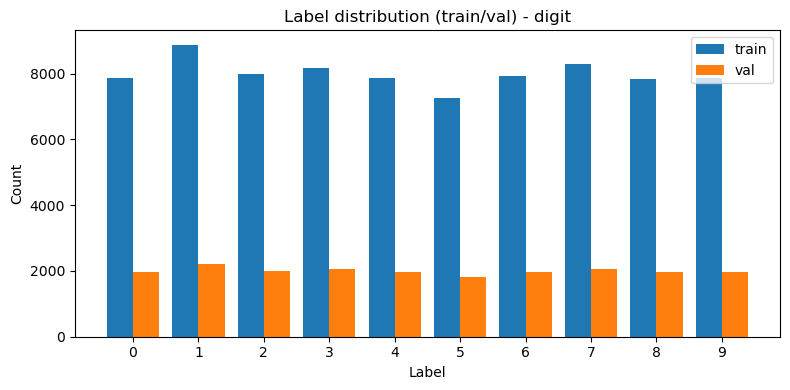

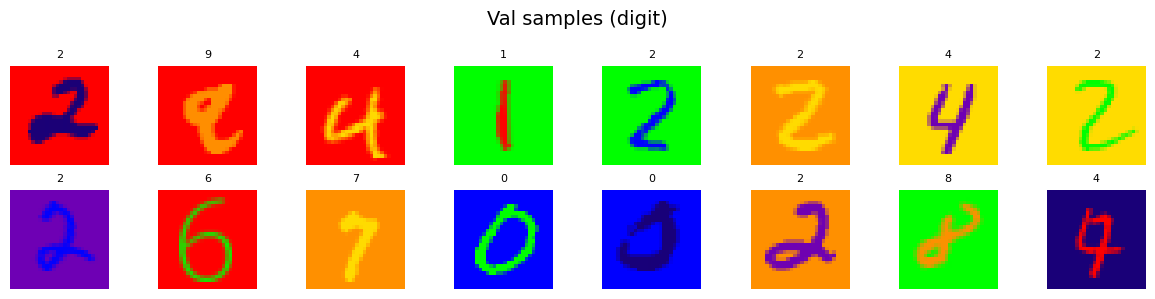


[TRAIN] Building pipeline for model = knn
[TRAIN] Fitting model...
[VAL] Predicting...

[VAL] Macro metrics (digit, model=knn)
  accuracy : 0.9020
  precision: 0.9061
  recall   : 0.9006
  f1-score : 0.9018

[VAL] classification_report:
              precision    recall  f1-score   support

           0     0.9386    0.9553    0.9469      1968
           1     0.8275    0.9883    0.9008      2218
           2     0.9679    0.8617    0.9117      1996
           3     0.9098    0.8876    0.8986      2046
           4     0.9245    0.8582    0.8901      1968
           5     0.9120    0.8719    0.8915      1819
           6     0.9258    0.9576    0.9414      1980
           7     0.8909    0.9175    0.9040      2073
           8     0.9354    0.8338    0.8816      1961
           9     0.8292    0.8742    0.8511      1971

    accuracy                         0.9020     20000
   macro avg     0.9061    0.9006    0.9018     20000
weighted avg     0.9051    0.9020    0.9019     20000

[IN

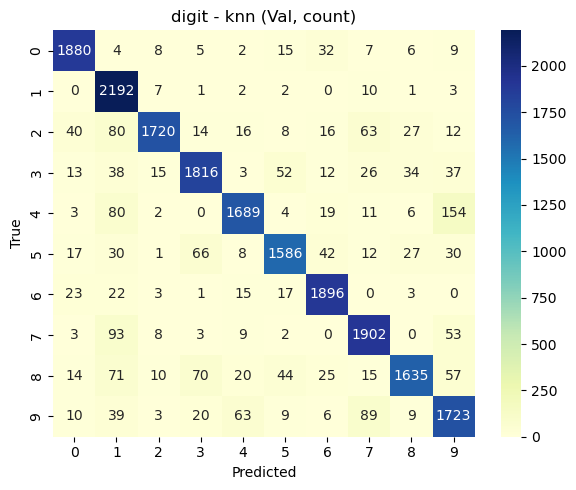

[INFO] Saved confusion matrix to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/figures/cm_digit_knn_val_normalized.png


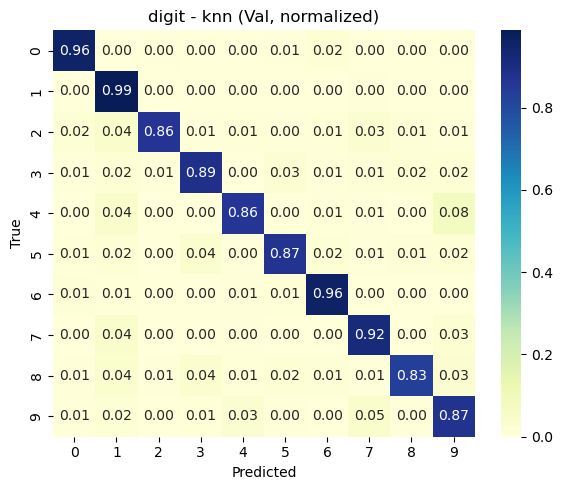


[VAL] Class-wise accuracy summary (digit):
        n_true  n_correct       acc
y_true                             
0         1968       1880  0.955285
1         2218       2192  0.988278
2         1996       1720  0.861723
3         2046       1816  0.887586
4         1968       1689  0.858232
5         1819       1586  0.871908
6         1980       1896  0.957576
7         2073       1902  0.917511
8         1961       1635  0.833758
9         1971       1723  0.874176
[INFO] Saved class-wise accuracy table to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/tables/class_accuracy_digit_knn.csv
[INFO] Saved class accuracy barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/figures/class_accuracy_digit_knn.png


/var/folders/rw/nyz2dwd5637cnd2y9j0spbr80000gn/T/ipykernel_22577/3837206026.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


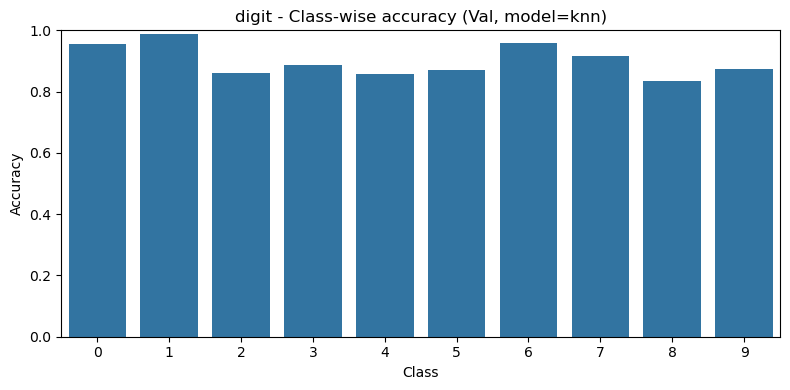


[VAL] Source-wise accuracy summary (digit):
            n  n_correct       acc
source                            
deskew   3973       3685  0.927511
font     2043       2043  1.000000
geom     2038       1393  0.683513
raw     11946      10918  0.913946
[INFO] Saved source-wise accuracy table to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/tables/source_accuracy_digit_knn.csv
[INFO] Saved source accuracy barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/figures/source_accuracy_digit_knn.png


/var/folders/rw/nyz2dwd5637cnd2y9j0spbr80000gn/T/ipykernel_22577/3837206026.py:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


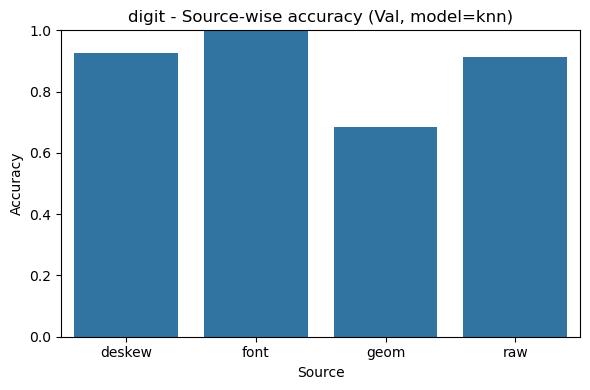


[VAL] Misclassified samples count (digit): 1961  / 20000 (error rate=0.0980)

[VAL] Top (true -> pred) confusion pairs (digit):
y_true  y_pred
4       9         154
7       1          93
9       7          89
2       1          80
4       1          80
8       1          71
        3          70
5       3          66
9       4          63
2       7          63
dtype: int64
[INFO] Saved misclassified samples table to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/tables/errors_digit_knn.csv


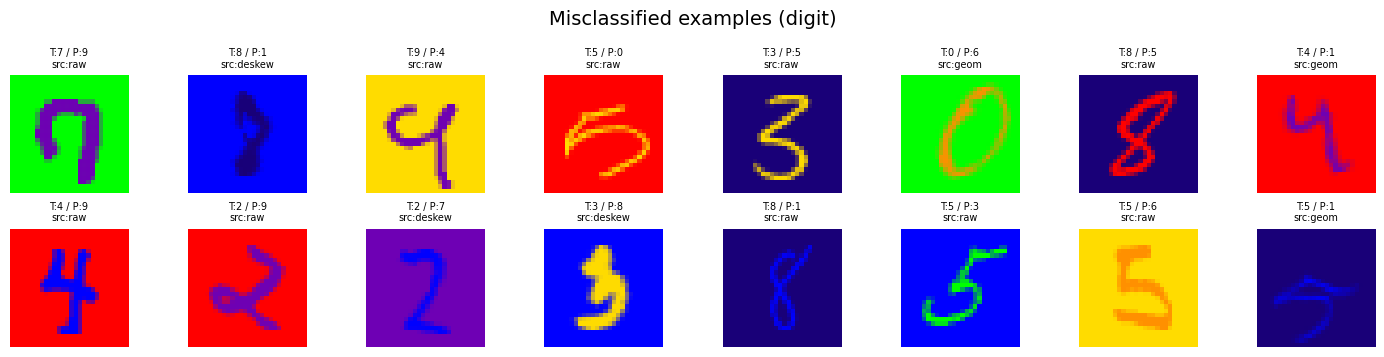



##########################################
### Task: fg - Foreground color classification (7 classes)
##########################################

[EDA] Label distribution for task = fg
       train   val
label             
0      11428  2915
1      11391  2860
2      11323  2908
3      11589  2855
4      11385  2809
5      11547  2847
6      11337  2806


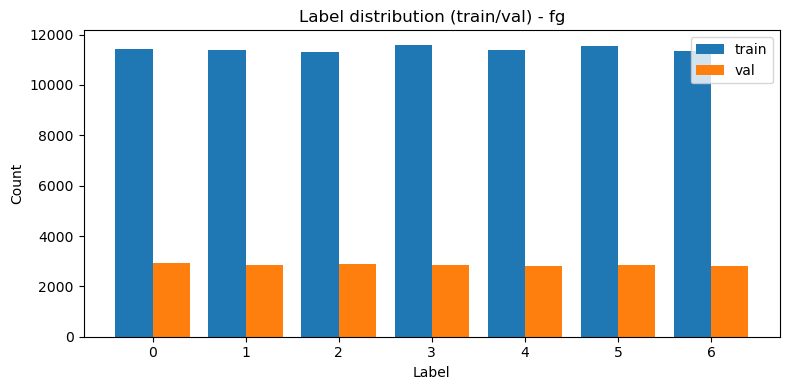

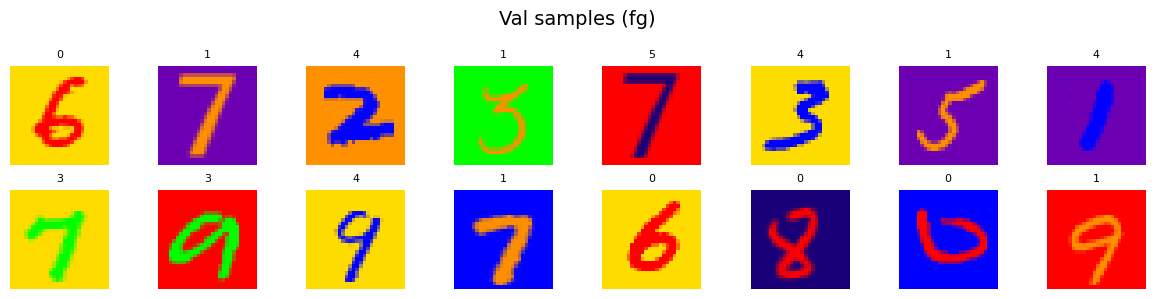


[TRAIN] Building pipeline for model = knn
[TRAIN] Fitting model...
[VAL] Predicting...

[VAL] Macro metrics (fg, model=knn)
  accuracy : 0.8514
  precision: 0.8757
  recall   : 0.8516
  f1-score : 0.8513

[VAL] classification_report:
              precision    recall  f1-score   support

           0     0.9840    0.8844    0.9315      2915
           1     0.6687    0.9031    0.7684      2860
           2     0.9084    0.6479    0.7563      2908
           3     1.0000    0.9751    0.9874      2855
           4     0.9963    0.6757    0.8053      2809
           5     0.8369    0.9642    0.8960      2847
           6     0.7358    0.9109    0.8140      2806

    accuracy                         0.8514     20000
   macro avg     0.8757    0.8516    0.8513     20000
weighted avg     0.8762    0.8514    0.8514     20000

[INFO] Saved confusion matrix to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/figures/cm_fg_knn_val_counts.png


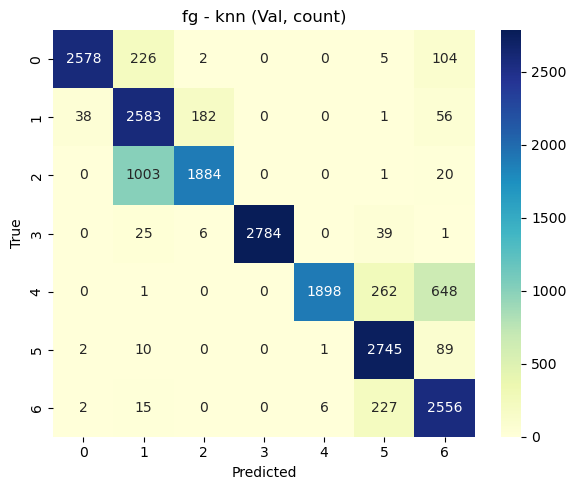

[INFO] Saved confusion matrix to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/figures/cm_fg_knn_val_normalized.png


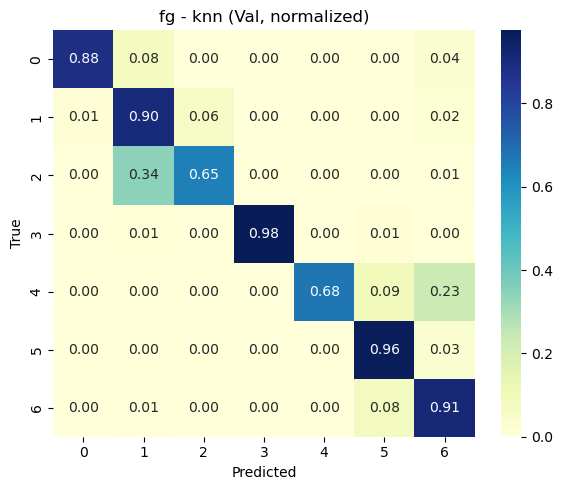


[VAL] Class-wise accuracy summary (fg):
        n_true  n_correct       acc
y_true                             
0         2915       2578  0.884391
1         2860       2583  0.903147
2         2908       1884  0.647868
3         2855       2784  0.975131
4         2809       1898  0.675685
5         2847       2745  0.964173
6         2806       2556  0.910905
[INFO] Saved class-wise accuracy table to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/tables/class_accuracy_fg_knn.csv
[INFO] Saved class accuracy barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/figures/class_accuracy_fg_knn.png


/var/folders/rw/nyz2dwd5637cnd2y9j0spbr80000gn/T/ipykernel_22577/3837206026.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


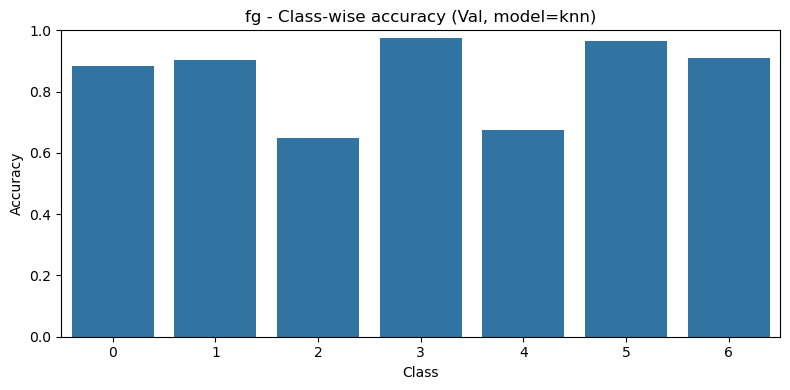


[VAL] Source-wise accuracy summary (fg):
            n  n_correct       acc
source                            
deskew   3973       3399  0.855525
font     2043       2035  0.996084
geom     2038       1544  0.757605
raw     11946      10050  0.841286
[INFO] Saved source-wise accuracy table to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/tables/source_accuracy_fg_knn.csv
[INFO] Saved source accuracy barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/figures/source_accuracy_fg_knn.png


/var/folders/rw/nyz2dwd5637cnd2y9j0spbr80000gn/T/ipykernel_22577/3837206026.py:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


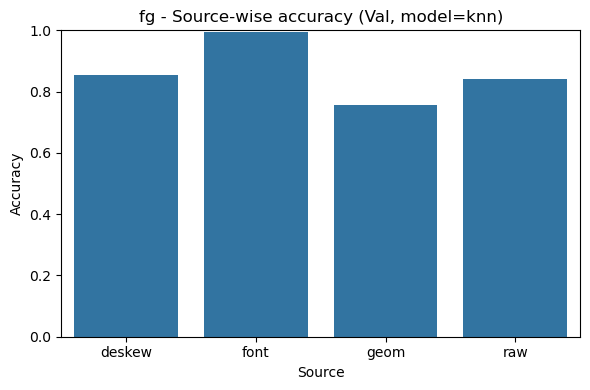


[VAL] Misclassified samples count (fg): 2972  / 20000 (error rate=0.1486)

[VAL] Top (true -> pred) confusion pairs (fg):
y_true  y_pred
2       1         1003
4       6          648
        5          262
6       5          227
0       1          226
1       2          182
0       6          104
5       6           89
1       6           56
3       5           39
dtype: int64
[INFO] Saved misclassified samples table to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/tables/errors_fg_knn.csv


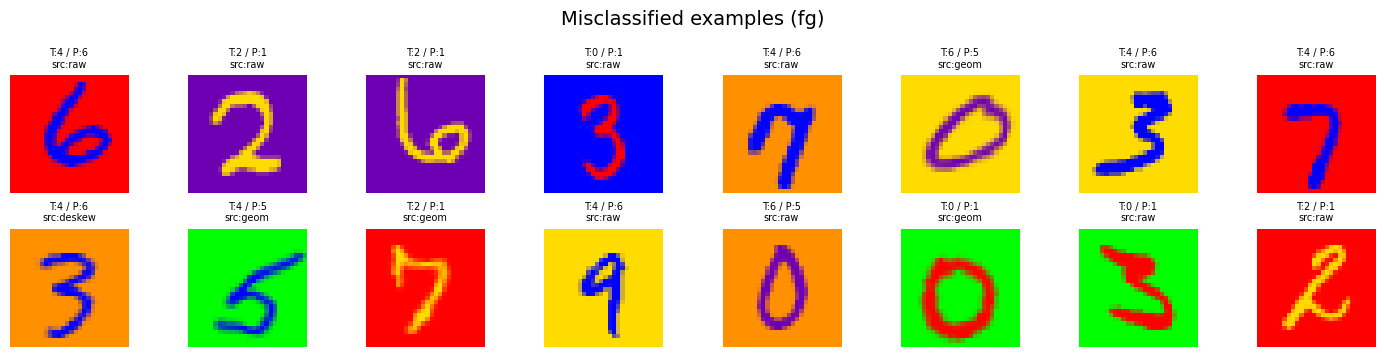



##########################################
### Task: bg - Background color classification (7 classes)
##########################################

[EDA] Label distribution for task = bg
       train   val
label             
0      11411  2877
1      11299  2818
2      11570  2816
3      11472  2856
4      11619  3001
5      11408  2849
6      11221  2783


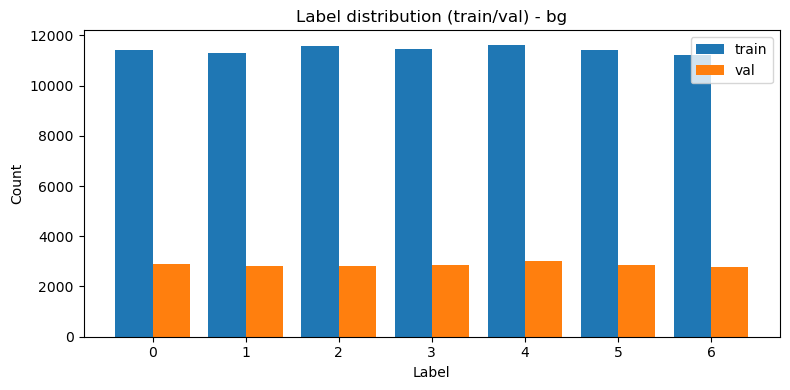

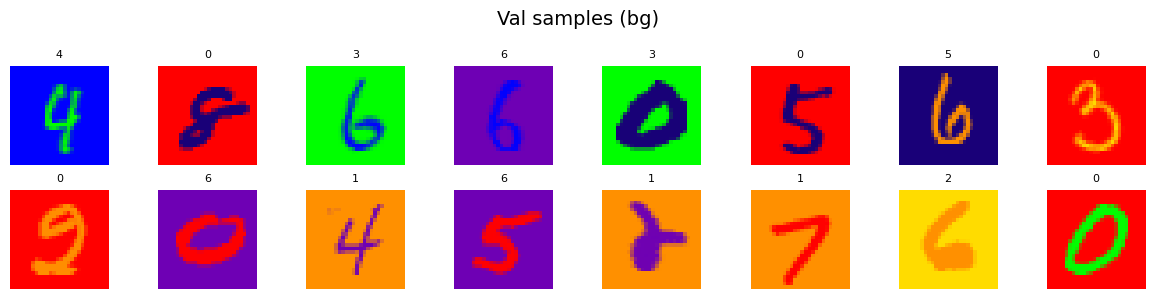


[TRAIN] Building pipeline for model = knn
[TRAIN] Fitting model...
[VAL] Predicting...

[VAL] Macro metrics (bg, model=knn)
  accuracy : 0.9999
  precision: 0.9998
  recall   : 0.9998
  f1-score : 0.9998

[VAL] classification_report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2877
           1     0.9989    1.0000    0.9995      2818
           2     1.0000    0.9989    0.9995      2816
           3     1.0000    1.0000    1.0000      2856
           4     1.0000    1.0000    1.0000      3001
           5     1.0000    1.0000    1.0000      2849
           6     1.0000    1.0000    1.0000      2783

    accuracy                         0.9999     20000
   macro avg     0.9998    0.9998    0.9998     20000
weighted avg     0.9999    0.9999    0.9998     20000

[INFO] Saved confusion matrix to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/figures/cm_bg_knn_val_counts.png


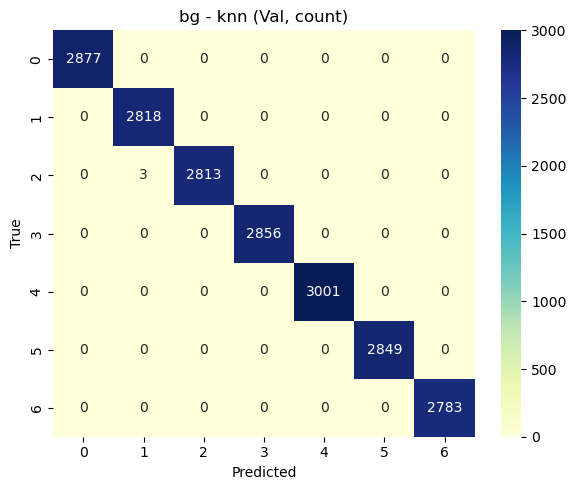

[INFO] Saved confusion matrix to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/figures/cm_bg_knn_val_normalized.png


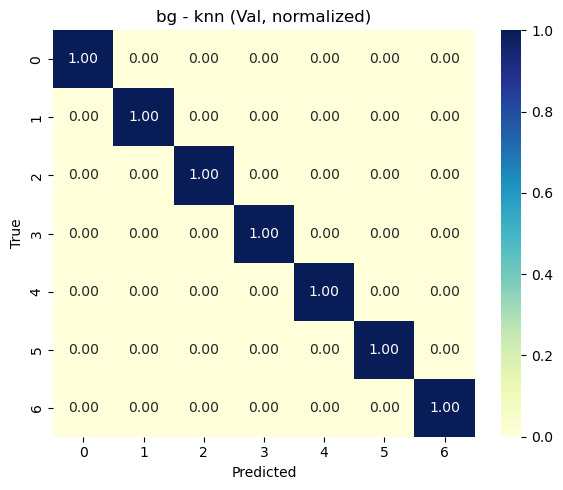


[VAL] Class-wise accuracy summary (bg):
        n_true  n_correct       acc
y_true                             
0         2877       2877  1.000000
1         2818       2818  1.000000
2         2816       2813  0.998935
3         2856       2856  1.000000
4         3001       3001  1.000000
5         2849       2849  1.000000
6         2783       2783  1.000000
[INFO] Saved class-wise accuracy table to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/tables/class_accuracy_bg_knn.csv
[INFO] Saved class accuracy barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/figures/class_accuracy_bg_knn.png


/var/folders/rw/nyz2dwd5637cnd2y9j0spbr80000gn/T/ipykernel_22577/3837206026.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


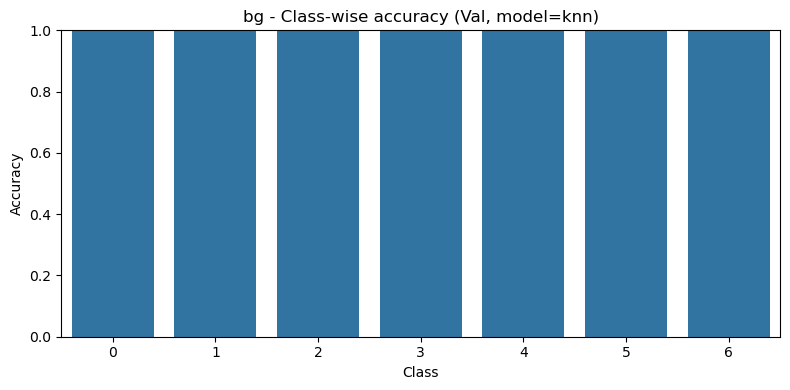


[VAL] Source-wise accuracy summary (bg):
            n  n_correct       acc
source                            
deskew   3973       3972  0.999748
font     2043       2043  1.000000
geom     2038       2037  0.999509
raw     11946      11945  0.999916
[INFO] Saved source-wise accuracy table to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/tables/source_accuracy_bg_knn.csv


/var/folders/rw/nyz2dwd5637cnd2y9j0spbr80000gn/T/ipykernel_22577/3837206026.py:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


[INFO] Saved source accuracy barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/figures/source_accuracy_bg_knn.png


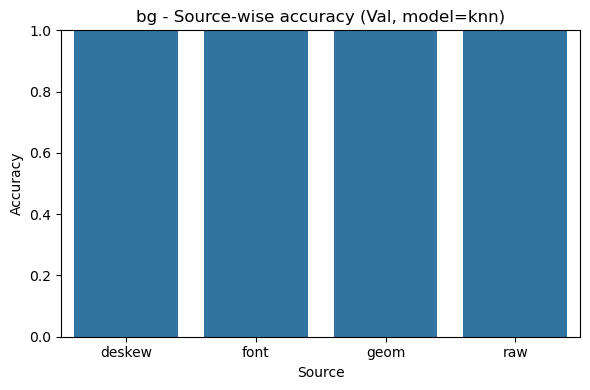


[VAL] Misclassified samples count (bg): 3  / 20000 (error rate=0.0001)

[VAL] Top (true -> pred) confusion pairs (bg):
y_true  y_pred
2       1         3
dtype: int64
[INFO] Saved misclassified samples table to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/tables/errors_bg_knn.csv


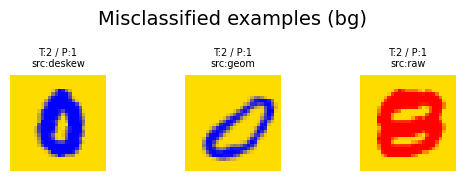


[INFO] Error analysis finished for all tasks.


In [15]:
# ==========================================
# Cell 8. Main error-analysis loop
# ==========================================
all_task_summary = []

for task_name in ACTIVE_TASKS:
    info = TASK_LABEL_INFO[task_name]
    y_train_task = info["y_train"]
    y_val_task   = info["y_val"]
    task_desc    = info["desc"]

    print("\n\n##########################################")
    print(f"### Task: {task_name} - {task_desc}")
    print("##########################################")

    # ---- 1) EDA: label distribution + 샘플 이미지 ----
    plot_label_distribution_simple(y_train_task, y_val_task, task_name)
    plot_sample_images(X_val, y_val_task, title=f"Val samples ({task_name})", n_samples=16)

    # ---- 2) 모델 학습 (train -> val) ----
    print(f"\n[TRAIN] Building pipeline for model = {TARGET_MODEL_NAME}")
    pipe = build_pipeline(TARGET_MODEL_NAME)

    print("[TRAIN] Fitting model...")
    pipe.fit(X_train, y_train_task)

    print("[VAL] Predicting...")
    y_val_pred = pipe.predict(X_val)

    acc, prec, rec, f1 = compute_metrics(y_val_task, y_val_pred, average="macro")
    print(f"\n[VAL] Macro metrics ({task_name}, model={TARGET_MODEL_NAME})")
    print(f"  accuracy : {acc:.4f}")
    print(f"  precision: {prec:.4f}")
    print(f"  recall   : {rec:.4f}")
    print(f"  f1-score : {f1:.4f}")

    print("\n[VAL] classification_report:")
    print(classification_report(y_val_task, y_val_pred, digits=4))

    # ---- 3) Confusion matrix (raw + normalized) ----
    classes = np.sort(np.unique(y_val_task))

    cm_title = f"{task_name} - {TARGET_MODEL_NAME} (Val, count)"
    cm_path  = os.path.join(FIGURES_DIR, f"cm_{task_name}_{TARGET_MODEL_NAME}_val_counts.png")
    plot_confusion_matrix(
        y_true=y_val_task,
        y_pred=y_val_pred,
        classes=classes,
        title=cm_title,
        save_path=cm_path,
        normalize=False,
    )

    cmn_title = f"{task_name} - {TARGET_MODEL_NAME} (Val, normalized)"
    cmn_path  = os.path.join(FIGURES_DIR, f"cm_{task_name}_{TARGET_MODEL_NAME}_val_normalized.png")
    plot_confusion_matrix(
        y_true=y_val_task,
        y_pred=y_val_pred,
        classes=classes,
        title=cmn_title,
        save_path=cmn_path,
        normalize=True,
    )

    # ---- 4) Per-class accuracy / error rate ----
    df_val = pd.DataFrame({
        "idx": np.arange(len(y_val_task)),
        "y_true": y_val_task,
        "y_pred": y_val_pred,
        "source": source_val,
    })

    # class-wise summary
    class_summary = (
        df_val
        .groupby("y_true")
        .apply(lambda g: pd.Series({
            "n_true": len(g),
            "n_correct": (g["y_true"] == g["y_pred"]).sum(),
        }))
    )
    class_summary["acc"] = class_summary["n_correct"] / class_summary["n_true"]

    print(f"\n[VAL] Class-wise accuracy summary ({task_name}):")
    print(class_summary)

    # 저장
    class_csv_path = os.path.join(
        TABLES_DIR, f"class_accuracy_{task_name}_{TARGET_MODEL_NAME}.csv"
    )
    class_summary.to_csv(class_csv_path)
    print("[INFO] Saved class-wise accuracy table to:", class_csv_path)

    # 시각화
    class_plot_title = f"{task_name} - Class-wise accuracy (Val, model={TARGET_MODEL_NAME})"
    class_plot_path  = os.path.join(
        FIGURES_DIR, f"class_accuracy_{task_name}_{TARGET_MODEL_NAME}.png"
    )
    plot_class_accuracy_bar(class_summary, class_plot_title, class_plot_path)

    # ---- 5) Source-wise accuracy (raw / deskew / font / geom) ----
    source_summary = (
        df_val
        .groupby("source")
        .apply(lambda g: pd.Series({
            "n": len(g),
            "n_correct": (g["y_true"] == g["y_pred"]).sum(),
        }))
    )
    source_summary["acc"] = source_summary["n_correct"] / source_summary["n"]

    print(f"\n[VAL] Source-wise accuracy summary ({task_name}):")
    print(source_summary)

    source_csv_path = os.path.join(
        TABLES_DIR, f"source_accuracy_{task_name}_{TARGET_MODEL_NAME}.csv"
    )
    source_summary.to_csv(source_csv_path)
    print("[INFO] Saved source-wise accuracy table to:", source_csv_path)

    source_plot_title = f"{task_name} - Source-wise accuracy (Val, model={TARGET_MODEL_NAME})"
    source_plot_path  = os.path.join(
        FIGURES_DIR, f"source_accuracy_{task_name}_{TARGET_MODEL_NAME}.png"
    )
    plot_source_accuracy_bar(source_summary, source_plot_title, source_plot_path)

    # ---- 6) Misclassified samples df + 저장 ----
    df_errors = df_val[df_val["y_true"] != df_val["y_pred"]].copy()
    print(f"\n[VAL] Misclassified samples count ({task_name}): {len(df_errors)} "
          f" / {len(df_val)} (error rate={len(df_errors)/len(df_val):.4f})")

    # 가장 많이 헷갈리는 (true,pred) 조합 상위 몇 개
    pair_counts = (
        df_errors
        .groupby(["y_true", "y_pred"])
        .size()
        .sort_values(ascending=False)
    )
    print(f"\n[VAL] Top (true -> pred) confusion pairs ({task_name}):")
    print(pair_counts.head(10))

    # 저장
    error_csv_path = os.path.join(
        TABLES_DIR, f"errors_{task_name}_{TARGET_MODEL_NAME}.csv"
    )
    df_errors.to_csv(error_csv_path, index=False)
    print("[INFO] Saved misclassified samples table to:", error_csv_path)

    # ---- 7) Misclassified sample visualization ----
    show_misclassified_examples(
        X_val=X_val,
        df_errors=df_errors,
        task_name=task_name,
        n=16,
        random_state=RANDOM_SEED,
    )

    # ---- 8) 전체 요약 저장용 ----
    all_task_summary.append({
        "task": task_name,
        "task_desc": task_desc,
        "model": TARGET_MODEL_NAME,
        "n_val": len(df_val),
        "n_errors": len(df_errors),
        "error_rate": len(df_errors) / len(df_val),
        "acc_macro": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
    })

print("\n[INFO] Error analysis finished for all tasks.")

In [16]:
# ==========================================
# Cell 9. Global summary table
# ==========================================
summary_df = pd.DataFrame(all_task_summary)
summary_df = summary_df.sort_values(by="task").reset_index(drop=True)

print("\n===== Error-analysis summary across tasks =====")
print(summary_df)

summary_csv_path = os.path.join(
    TABLES_DIR, f"error_analysis_summary_{TARGET_MODEL_NAME}.csv"
)
summary_df.to_csv(summary_csv_path, index=False)
print("\n[INFO] Saved global error-analysis summary to:", summary_csv_path)


===== Error-analysis summary across tasks =====
    task                                    task_desc model  n_val  n_errors  \
0     bg  Background color classification (7 classes)   knn  20000         3   
1  digit                   Digit classification (0-9)   knn  20000      1961   
2     fg  Foreground color classification (7 classes)   knn  20000      2972   

   error_rate  acc_macro  precision_macro  recall_macro  f1_macro  
0     0.00015    0.99985         0.999848      0.999848  0.999848  
1     0.09805    0.90195         0.906147      0.900603  0.901768  
2     0.14860    0.85140         0.875711      0.851614  0.851282  

[INFO] Saved global error-analysis summary to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/error_analysis/tables/error_analysis_summary_knn.csv
